# A Python Tour of Data Science: Data Acquisition & Exploration     

[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

# 1 Exercise: problem definition

Theme of the exercise: **understand the impact of your communication on social networks**. A real life situation: the marketing team needs help in identifying which were the most engaging posts they made on social platforms to prepare their next [AdWords](https://www.google.com/adwords/) campaign.

As you probably don't have a company (yet?), you can either use your own social network profile as if it were the company's one or choose an established entity, e.g. EPFL. You will need to be registered in FB or Twitter to generate access tokens. If you're not, either ask a classmate to create a token for you or create a fake / temporary account for yourself (no need to follow other people, we can fetch public data).

At the end of the exercise, you should have two datasets (Facebook & Twitter) and have used them to answer the following questions, for both Facebook and Twitter.
1. How many followers / friends / likes has your chosen profile ?
2. How many posts / tweets in the last year ?
3. What were the 5 most liked posts / tweets ?
4. Plot histograms of number of likes and comments / retweets.
5. Plot basic statistics and an histogram of text lenght.
6. Is there any correlation between the lenght of the text and the number of likes ?
7. Be curious and explore your data. Did you find something interesting or surprising ?
    1. Create at least one interactive plot (with bokeh) to explore an intuition (e.g. does the posting time plays a role).

# 2 Ressources

Here are some links you may find useful to complete that exercise.

Web APIs: these are the references.
* [Facebook Graph API](https://developers.facebook.com/docs/graph-api)
* [Twitter REST API](https://dev.twitter.com/rest/public)

Tutorials:
* [Mining the Social Web](https://github.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition)
* [Mining Twitter data with Python](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)
* [Simple Python Facebook Scraper](http://simplebeautifuldata.com/2014/08/25/simple-python-facebook-scraper-part-1/)

# 3 Web scraping

Tasks:
1. Download the relevant information from Facebook and Twitter. Try to minimize the quantity of collected data to the minimum required to answer the questions.
2. Build two SQLite databases, one for Facebook and the other for Twitter, using [pandas](http://pandas.pydata.org/) and [SQLAlchemy](http://www.sqlalchemy.org/).
    1. For FB, each row is a post, and the columns are at least (you can include more if you want): the post id, the message (i.e. the text), the time when it was posted, the number of likes and the number of comments.
    2. For Twitter, each row is a tweet, and the columns are at least: the tweet id, the text, the creation time, the number of likes (was called favorite before) and the number of retweets.

Note that some data cleaning is already necessary. E.g. there are some FB posts without *message*, i.e. without text. Some tweets are also just retweets without any more information. Should they be collected ?

In [1]:
# Number of posts / tweets to retrieve.
# Small value for development, then increase to collect final data.
n = 4000  # 20

## 3.1 Facebook

There is two ways to scrape data from Facebook, you can choose one or combine them.
1. The low-level approach, sending HTTP requests and receiving JSON responses to / from their Graph API. That can be achieved with the json and [requests](python-requests.org) packages (altough you can use urllib or urllib2, requests has a better API). The knowledge you'll acquire using that method will be useful to query other web APIs than FB. This method is also more flexible.
2. The high-level approach, using a [Python SDK](http://facebook-sdk.readthedocs.io). The code you'll have to write for this method is gonna be shorter, but specific to the FB Graph API.

You will need an access token, which can be created with the help of the [Graph Explorer](https://developers.facebook.com/tools/explorer). That tool may prove useful to test queries. Once you have your token, you may create a `credentials.ini` file with the following content:
```
[facebook]
token = YOUR-FB-ACCESS-TOKEN
```

In [2]:
import configparser

# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
token = credentials.get('facebook', 'token')

# Or token = 'YOUR-FB-ACCESS-TOKEN'

In [3]:
import requests  # pip install requests
import facebook  # pip install facebook-sdk
import pandas as pd

In [4]:
page = 'EPFL.ch'

### 3.1.1 Scrap with HTTP requests

#### 3.1.1.1 Get the number of likes

The process is three-way:
1. Assemble an URL to query. The documentation of the FB Graph API is useful there. You can click on the URL to let your browser make the query and return the result.
2. Send an HTTP GET request, receive the results and interpret it as JSON (because Facebook sends data in JSON).
3. Explore the received data and extract what interests us, here the number of likes. If we don't get what we want (or if we get too much), we can modify the query url. Note that the hierarchical JSON format is exposed as a dictionary.

In [5]:
# 1. Form URL.
url = 'https://graph.facebook.com/{}?fields=likes&access_token={}'.format(page, token)
#print(url)

# 2. Get data.
data = requests.get(url).json()
print('data:', data)

# Optionally, check for errors. Most probably the session has expired.
if 'error' in data.keys():
    raise Exception(data)

# 3. Extract data.
print('{} has {} likes'.format(page, data['likes']))

data: {'likes': 62190, 'id': '107201356009441'}
EPFL.ch has 62190 likes


#### 3.1.1.2 Get posts

The process is similar here, except that the query and extraction are more complicated (because we work with more data). As you may have found out, FB returns at most 100 posts at a time. To get more posts, they provide *paging*, which we use to requests the next posts.

In [6]:
# 1. Form URL. You can click that url and see the returned JSON in your browser.
fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limit(0).summary(1)'
url = 'https://graph.facebook.com/{}/posts?fields={}&access_token={}'.format(page, fields, token)
#print(url)

# Create the pandas DataFrame, a table which columns are post id, message, created time, #likes and #comments.
fb = pd.DataFrame(columns=['id', 'text', 'time', 'likes', 'comments'])

# The outer loop is to query FB multiple times, as FB sends at most 100 posts at a time.
while len(fb) < n:
    
    # 2. Get the data from FB. At most 100 posts.
    posts = requests.get(url).json()

    # 3. Here we extract information for each of the received post.
    for post in posts['data']:
        # The information is stored in a dictionary.
        serie = dict(id=post['id'], time=post['created_time'])
        try:
            serie['text'] = post['message']
        except KeyError:
            # Let's say we are not interested in posts without text.
            continue
        serie['likes'] = post['likes']['summary']['total_count']
        serie['comments'] = post['comments']['summary']['total_count']
        # Add the dictionary as a new line to our pandas DataFrame.
        fb = fb.append(serie, ignore_index=True)
    
    try:
        # That URL is returned by FB to access the next 'page', i.e. the next 100 posts.
        url = posts['paging']['next']
    except KeyError:
        # No more posts.
        break

In [7]:
fb[:5]

,id,text,time,likes,comments
0,107201356009441_1346592535403644,Two architecture student turn downtown Lausann...,2016-10-21T17:00:01+0000,122.0,1.0
1,107201356009441_1346583242071240,Adding a single chemical when making biofuels ...,2016-10-21T13:20:04+0000,39.0,0.0
2,107201356009441_1345683875494510,Une très belle lumière ce soir sur le campus!,2016-10-20T17:07:48+0000,523.0,6.0
3,107201356009441_1345641658832065,New online programs offered by the EPFL Extens...,2016-10-20T16:26:03+0000,79.0,2.0
4,107201356009441_1345339838862247,Voici quelques unes des photos postées pour le...,2016-10-20T13:40:11+0000,81.0,1.0


### 3.1.2 Scrap with Facebook SDK

That method is much slower because it should retrieve the comments and likes, not only their number, for each post. The API is not expressive enough to do otherwise.

In [8]:
g = facebook.GraphAPI(token, version='2.7')

# We limit to 10 because it's slow.
posts = g.get_connections(page, 'posts', limit=10)

if 'error' in posts.keys():
    # Most probably the session has expired.
    raise Exception(data)

for post in posts['data']:
    pid = post['id']
    try:
        text = post['message']
    except KeyError:
        continue
    time = post['created_time']
    likes = g.get_connections(pid, 'likes', summary=True, limit=0)
    nlikes = likes['summary']['total_count']
    comments = g.get_connections(pid, 'comments', summary=True, limit=0)
    ncomments = comments['summary']['total_count']
    print('{:6d} {:6d} {} {}'.format(nlikes, ncomments, time, text[:50]))

   122      1 2016-10-21T17:00:01+0000 Two architecture student turn downtown Lausanne in
    39      0 2016-10-21T13:20:04+0000 Adding a single chemical when making biofuels can 
   523      6 2016-10-20T17:07:48+0000 Une très belle lumière ce soir sur le campus!
    79      2 2016-10-20T16:26:03+0000 New online programs offered by the EPFL Extension 
    81      1 2016-10-20T13:40:11+0000 Voici quelques unes des photos postées pour le con
   296     18 2016-10-19T14:06:51+0000 Just like Eva, our young astronaut, come and disco
   106      3 2016-10-19T07:52:12+0000 Le projet du Students Center, futur lieu qui sera 
   132      7 2016-10-18T14:57:00+0000 On October 17 2016, The President of the Portugues
    81      3 2016-10-18T11:51:48+0000 This 3D interactive "galaxy" designed by an EPFL P
   148      1 2016-10-17T07:31:18+0000 Bacteria could prevent radioactive leaks in underg


## 3.2 Twitter

There exists a bunch of [Python-based clients](https://dev.twitter.com/overview/api/twitter-libraries#python) for Twitter. [Tweepy](http://tweepy.readthedocs.io) is a popular choice.

You will need to create a [Twitter app](https://apps.twitter.com/) and copy the four tokens and secrets in the `credentials.ini` file:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```

In [9]:
import tweepy  # pip install tweepy

auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))
api = tweepy.API(auth)

user = 'EPFL_en'

In [10]:
followers = api.get_user(user).followers_count
print('{} has {} followers'.format(user, followers))

EPFL_en has 17978 followers


The code is much simpler for Twitter than Facebook because Tweepy handles much of the dirty work, like paging.

In [11]:
tw = pd.DataFrame(columns=['id', 'text', 'time', 'likes', 'shares'])
for tweet in tweepy.Cursor(api.user_timeline, screen_name=user).items(n):
    serie = dict(id=tweet.id, text=tweet.text, time=tweet.created_at)
    serie.update(dict(likes=tweet.favorite_count, shares=tweet.retweet_count))
    tw = tw.append(serie, ignore_index=True)

# 4 Prepare and save data

To facilitate our analysis, we first prepare the data.
1. Convert floating point numbers to integers.
1. Convert Facebook post time from string to datetime.

That is not necessary, but it'll allow to e.g. compare posting dates with standard comparison operators like `>` and `<`.

In [12]:
#fb.id = fb.id.astype(int)
fb.likes = fb.likes.astype(int)
fb.comments = fb.comments.astype(int)

tw.id = tw.id.astype(int)
tw.likes = tw.likes.astype(int)
tw.shares = tw.shares.astype(int)

In [13]:
from datetime import datetime

def convert_time(row):
    return datetime.strptime(row['time'], '%Y-%m-%dT%H:%M:%S+0000')

fb['time'] = fb.apply(convert_time, axis=1)

In [14]:
from IPython.display import display
display(fb[:5])
display(tw[:5])

,id,text,time,likes,comments
0,107201356009441_1346592535403644,Two architecture student turn downtown Lausann...,2016-10-21 17:00:01,122,1
1,107201356009441_1346583242071240,Adding a single chemical when making biofuels ...,2016-10-21 13:20:04,39,0
2,107201356009441_1345683875494510,Une très belle lumière ce soir sur le campus!,2016-10-20 17:07:48,523,6
3,107201356009441_1345641658832065,New online programs offered by the EPFL Extens...,2016-10-20 16:26:03,79,2
4,107201356009441_1345339838862247,Voici quelques unes des photos postées pour le...,2016-10-20 13:40:11,81,1


,id,text,time,likes,shares
0,789509789755830272,Architecture students design a car-free Lausan...,2016-10-21 16:52:56,5,3
1,789500337619083264,A vitamin could help treat Duchenne muscular d...,2016-10-21 16:15:23,0,1
2,789492707790028800,RT @epfl_exts: Thanks to @EPFL president Patri...,2016-10-21 15:45:04,0,5
3,789471927735840768,A single chemical can transform a waste produc...,2016-10-21 14:22:29,4,5
4,789470735093956608,RT @physorg_com: Turning biofuel waste into we...,2016-10-21 14:17:45,0,11


Now that we collected everything, let's save it in two SQLite databases.

In [15]:
import os

folder = os.path.join('..', 'data', 'social_media')
try:
    os.makedirs(folder)
except FileExistsError:
    pass

filename = os.path.join(folder, 'facebook.sqlite')
fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')

filename = os.path.join(folder, 'twitter.sqlite')
tw.to_sql('twitter', 'sqlite:///' + filename, if_exists='replace')

# 5 Data analysis

Answer the questions using [pandas](http://pandas.pydata.org/), [statsmodels](http://statsmodels.sourceforge.net/), [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html), [bokeh](http://bokeh.pydata.org).

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## 5.1 Number of posts

In [17]:
date = datetime(2016, 9, 4)
datestr = date.strftime('%Y-%m-%d')
print('Number of posts after {}: {}'.format(datestr, sum(fb.time > date)))
print('Number of tweets after {}: {}'.format(datestr, sum(tw.time > date)))

Number of posts after 2016-09-04: 58
Number of tweets after 2016-09-04: 131


## 5.2 Most liked

Looks like we're really into rankings !!

In [18]:
display(fb.sort_values(by='likes', ascending=False)[:5])
display(tw.sort_values(by='likes', ascending=False)[:5])

,id,text,time,likes,comments
578,107201356009441_525252137537692,L'EPFL est la 13ème université mondiale (et la...,2013-04-23 09:13:51,1608,52
210,107201356009441_1179534925442740,"EPFL tops the ""150 best young universities in ...",2016-04-07 05:45:00,1316,15
55,107201356009441_1299919223404309,EPFL retains its 14th place in the QS World Un...,2016-09-06 12:52:13,1104,31
129,107201356009441_1229728187090080,"EPFL placed 4th in Reuters' ""Europe's Most Inn...",2016-06-16 10:30:00,1082,16
178,107201356009441_1203053033090929,Université de Lausanne's sheep ain't no match....,2016-05-09 12:40:20,1046,12


,id,text,time,likes,shares
1026,572353276261367808,EPFL researchers finally managed to see #light...,2015-03-02 11:10:29,33,45
473,702448909180870656,Martin Vetterli will be the next president of ...,2016-02-24 11:04:05,29,54
978,583714121436307456,EPFL just hosted the press conference on the h...,2015-04-02 19:34:26,25,31
396,715833683022888960,Mini black holes created at EPFL allow dog to ...,2016-04-01 09:30:24,22,21
432,707559328673357824,EPFL &amp; @ICRC launch the Humanitarian Tech ...,2016-03-09 13:31:04,21,41


## 5.3 Engagement: likes, comments, shares

In [19]:
pd.concat([fb.describe(), tw.loc[:,'likes':'shares'].describe()], axis=1)

,likes,comments,likes,shares
count,816.000000,816.000000,3211.000000,3211.000000
mean,103.524510,3.088235,0.968857,5.792588
std,166.370691,5.561662,2.415996,112.030662
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000
50%,42.000000,1.000000,0.000000,1.000000
75%,113.250000,3.250000,1.000000,3.000000
max,1608.000000,52.000000,33.000000,6063.000000


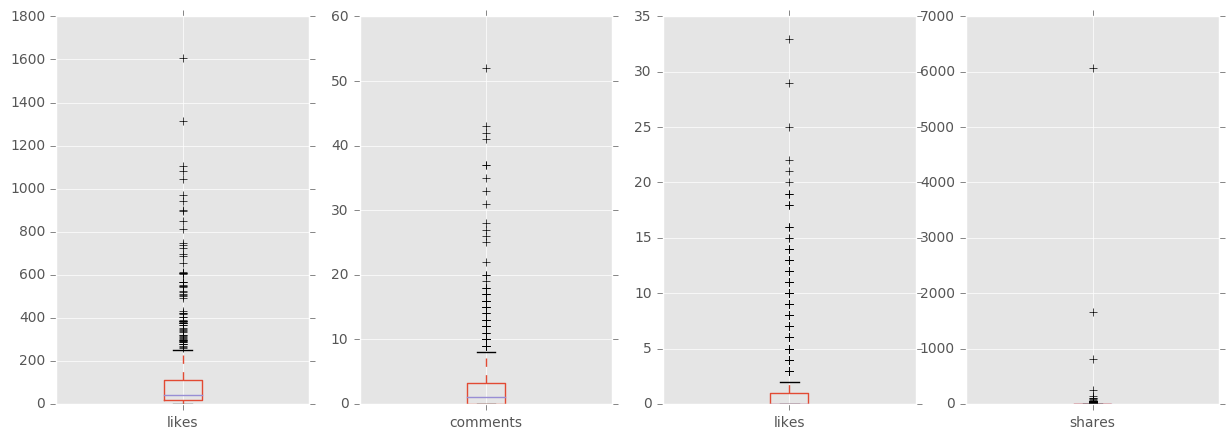

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fb.likes.plot(kind='box', ax=axs[0]);
fb.comments.plot(kind='box', ax=axs[1]);
tw.likes.plot(kind='box', ax=axs[2]);
tw.shares.plot(kind='box', ax=axs[3]);

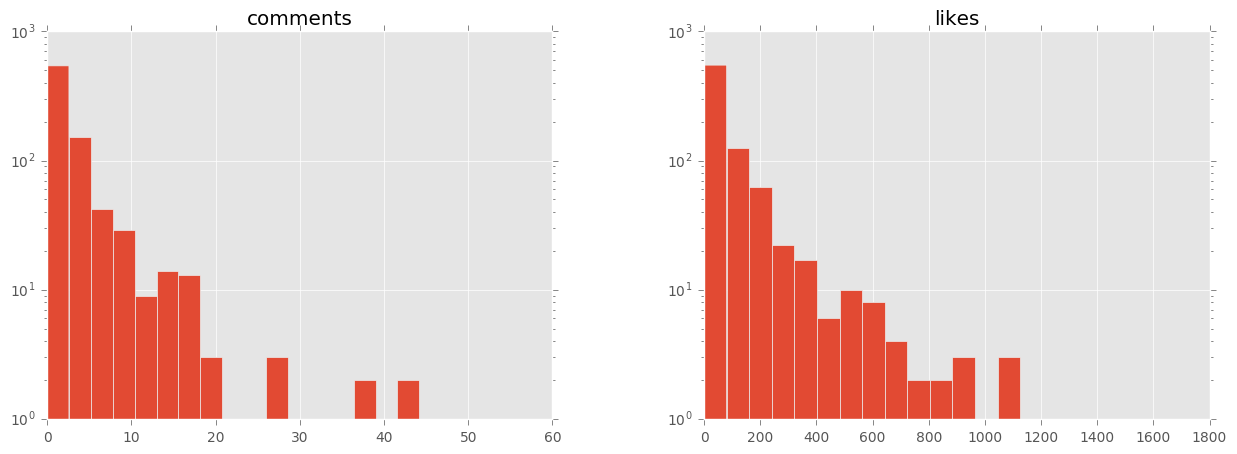

In [21]:
fb.hist(bins=20, log=True, figsize=(15, 5));

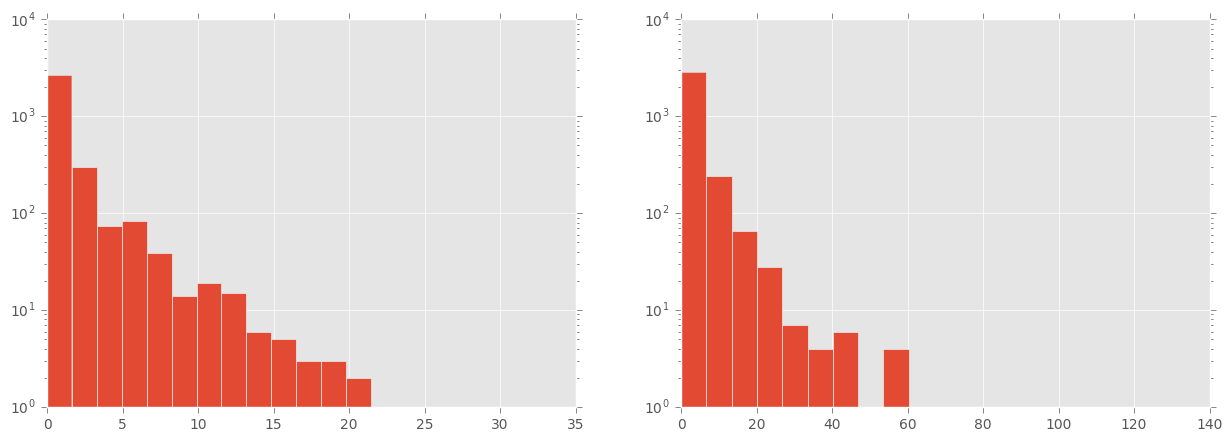

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
tw.loc[:,'likes'].hist(bins=20, log=True, ax=axs[0]);
tw.loc[tw.shares < 200, 'shares'].hist(bins=20, log=True, ax=axs[1]);

## 5.4 Text length

There is a stricking difference here:
1. On Twitter, almost all tweets reach the 140 characters limit.
2. The distribution is more Gaussian on Facebook.

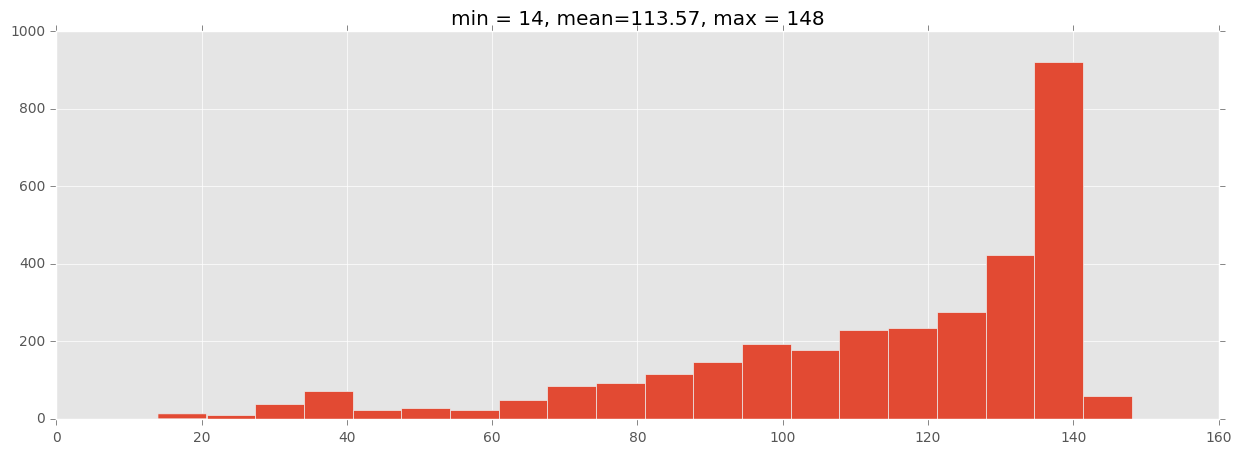

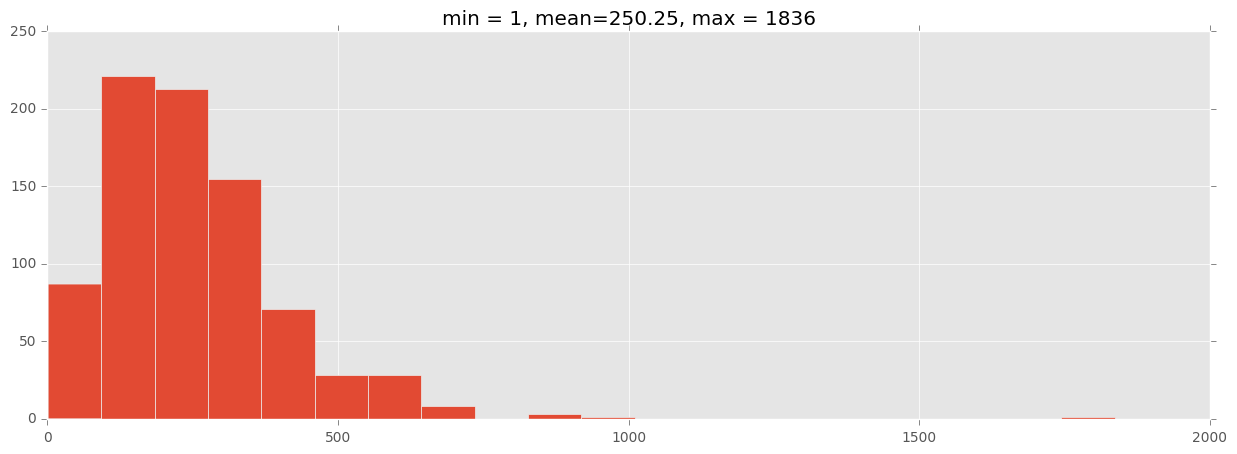

In [23]:
def text_length(texts):
    lengths = np.empty(len(texts), dtype=int)
    for i, text in enumerate(texts):
        lengths[i] = len(text)
    plt.figure(figsize=(15, 5))
    prop = lengths.min(), '{:.2f}'.format(lengths.mean()), lengths.max()
    plt.title('min = {}, mean={}, max = {}'.format(*prop))
    plt.hist(lengths, bins=20)

text_length(tw.text)
text_length(fb.text)

## 5.5 Posting time

We can clearly observe the office hours.

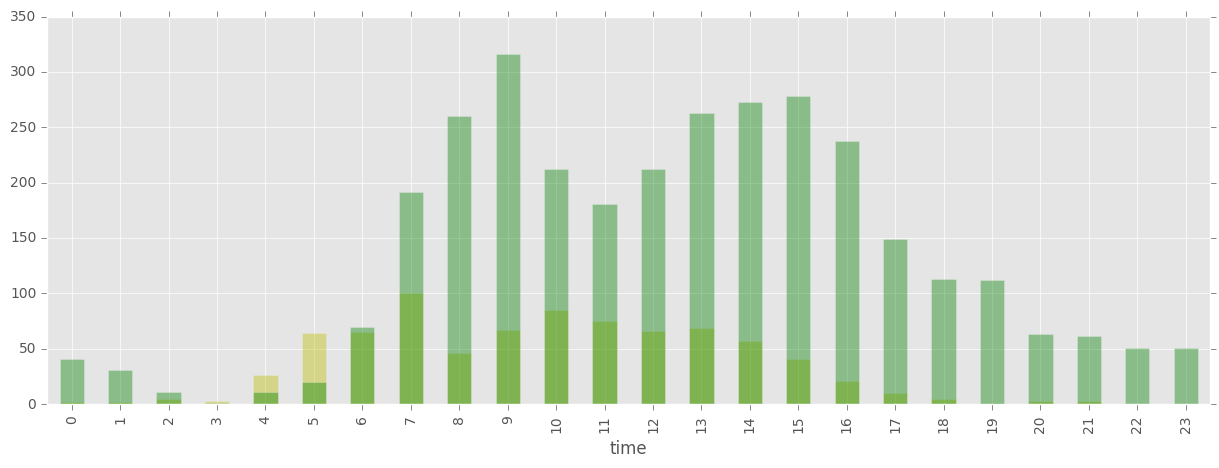

In [24]:
fb.id.groupby(fb.time.dt.hour).count().plot(kind='bar', alpha=0.4, color='y', figsize=(15,5));
tw.id.groupby(tw.time.dt.hour).count().plot(kind='bar', alpha=0.4, color='g', figsize=(15,5));

Let's look if the time of posting influence the number of likes. Do you see a peak at 5am ? Do you really think we should post at 5am ? What's going on here ?

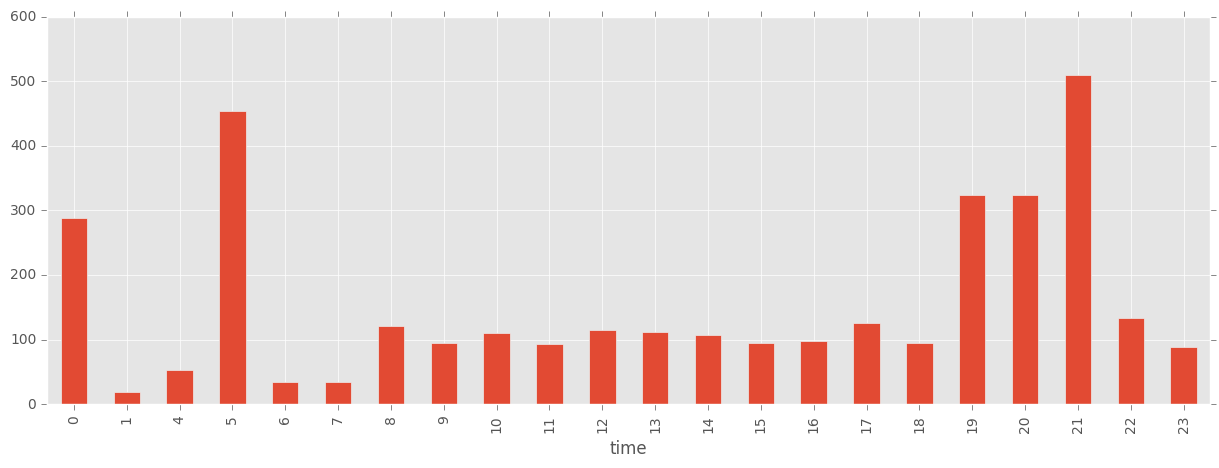

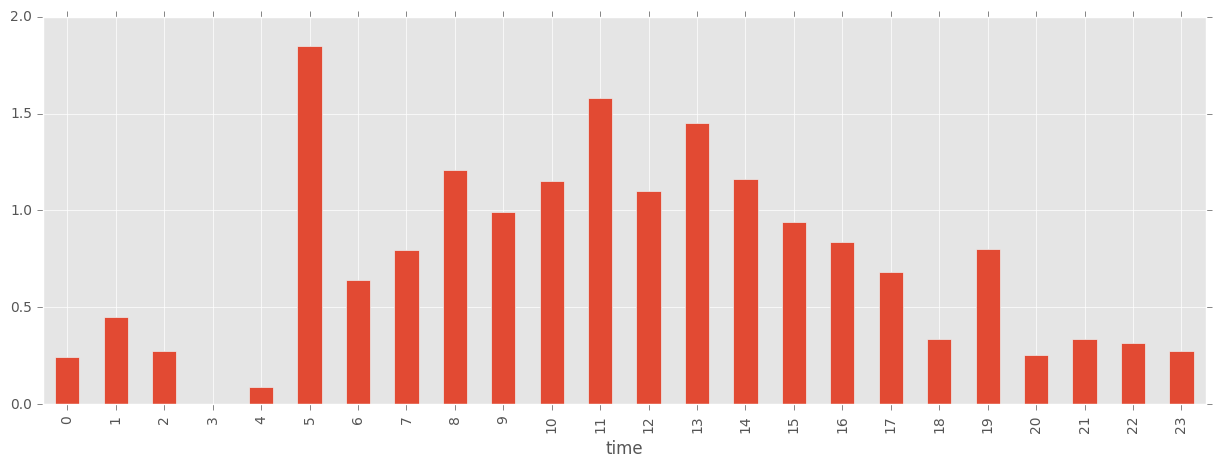

In [25]:
fb.likes.groupby(fb.time.dt.hour).mean().plot(kind='bar', figsize=(15,5));
plt.figure()
tw.likes.groupby(tw.time.dt.hour).mean().plot(kind='bar', figsize=(15,5));